In [1]:
import cv2 
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR='train'
TEST_DIR='test'
IMG_SIZE=50
LR=1e-3
MODEL_NAME='dogvscat-{}-{}.model'.format(LR,'2conv-basic')

In [3]:
def label_img(img):
    word_label=img.split('.')[-3]
    
    if word_label=='cat':
        return [1,0]
    elif word_label=='dog':
        return [0,1]


In [4]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
        
    
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

    

In [21]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        
        testing_data.append([np.array(img),img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy',testing_data)
    
    return testing_data


In [6]:
train_data=create_train_data()

100%|███████████████████████████████████| 25000/25000 [01:18<00:00, 317.56it/s]


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout,fully_connected
from tflearn.layers.estimator import regression



C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [8]:
# Build the model

convnet=input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)


convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)


convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)


convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=fully_connected(convnet,1024 ,activation='relu')
convnet=dropout(convnet,0.8)

convnet=fully_connected(convnet,2,activation='softmax')
convnet=regression(convnet,optimizer='adam',learning_rate=LR,loss='categorical_crossentropy',name='targets')

model=tflearn.DNN(convnet,tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded')
    

In [10]:
train=train_data[:-500]
test=train_data[-500:]

In [11]:
X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)

Y=[i[1] for i in train]

x_test=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)

y_test=[i[1] for i in test]

In [12]:
model.fit({'input':X},{'targets':Y},n_epoch=2,validation_set=({'input':x_test},{'targets':y_test}),snapshot_step=50000,
          show_metric=True,run_id=MODEL_NAME)

Training Step: 765  | total loss: 0.47705 | time: 831.900s
| Adam | epoch: 002 | loss: 0.47705 - acc: 0.7716 -- iter: 24448/24500
Training Step: 766  | total loss: 0.47071 | time: 835.143s
| Adam | epoch: 002 | loss: 0.47071 - acc: 0.7741 | val_loss: 0.51893 - val_acc: 0.7280 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\user\Downloads\Projects\Cat Vs Dog\dogvscat-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|███████████████████████████████████| 12500/12500 [00:38<00:00, 328.77it/s]


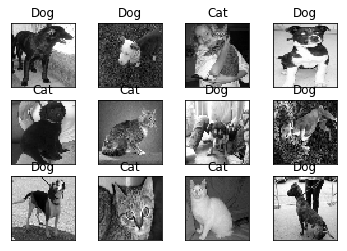

In [44]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [46]:
# create a empty csv fil
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
    
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num=data[1]
        img_data=data[0]
        orig=img_data
        data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out=model.predict([data])[0]
        
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████████████| 12500/12500 [00:17<00:00, 728.39it/s]
